# End-to-End Emotion Chatbot Demo

This notebook demonstrates the complete flow of an emotion-aware chatbot which:
- Predicts the user’s emotion from their message using a fine-tuned emotion classifier.
- Generates an emotionally tailored response using a large language model (LLM).

You can interactively test the chatbot by typing messages and seeing the detected emotion and bot reply.


In [4]:
import sys
import os

# Adjust this path to point to the root directory of your project (the one containing 'services/')
PROJECT_ROOT = os.path.abspath("..")  # if you're in notebooks/, go one level up
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)


In [5]:
# Import necessary libraries and your service modules
from services.nlp_services import EmotionClassifierService
from services.generation_services import ResponseGeneratorService

import torch
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Check device
print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")


Using device: cpu


In [6]:
from services.nlp_services import EmotionClassifierService
from services.generation_services import ResponseGeneratorService

# Paths and models
EMOTION_MODEL_PATH = '../data/models/meld_emotion_model'
GENERATION_MODEL_NAME = 'mistralai/Mistral-7B-Instruct-v0.2'
HF_TOKEN = None

# Define MELD label map manually
LABEL_MAP = {
    0: "anger",
    1: "disgust",
    2: "fear",
    3: "joy",
    4: "neutral",
    5: "sadness",
    6: "surprise"
}

# Create service instances
emotion_classifier = EmotionClassifierService(model_name=EMOTION_MODEL_PATH, label_map=LABEL_MAP, hf_token=HF_TOKEN)
response_generator = ResponseGeneratorService(model_name=GENERATION_MODEL_NAME, hf_token=HF_TOKEN)


W0801 11:14:35.655000 21112 Lib\site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
# Define the chatbot pipeline function
def chatbot_reply(user_message: str):
    # Step 1: Emotion detection
    emotion = emotion_classifier.predict(user_message)

    # Step 2: Generate response conditioned on the detected emotion
    response = response_generator.generate_response(user_message, emotion)

    return emotion, response


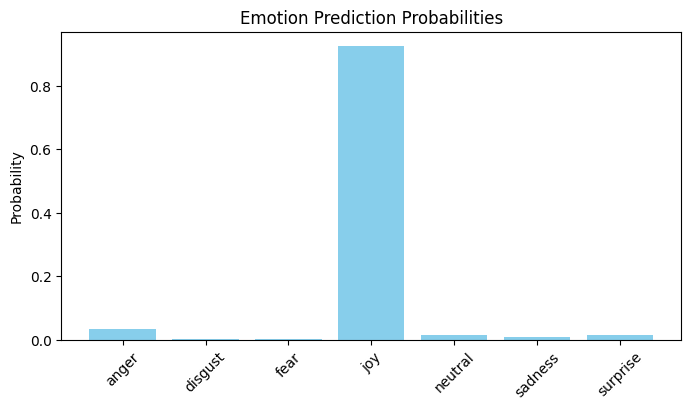

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

def plot_emotion_probabilities(text):
    probs = emotion_classifier.predict_proba(text)
    plt.figure(figsize=(8,4))
    plt.bar(probs.keys(), probs.values(), color='skyblue')
    plt.title("Emotion Prediction Probabilities")
    plt.ylabel("Probability")
    plt.xticks(rotation=45)
    plt.show()

plot_emotion_probabilities("I'm feeling really happy today!")


In [11]:
from IPython.display import display, clear_output
import ipywidgets as widgets

# --- Input widgets ---
user_input = widgets.Text(
    value='',
    placeholder='Type your message here...',
    description='You:',
    layout=widgets.Layout(width='70%')
)

send_button = widgets.Button(
    description='Send',
    button_style='success',
    tooltip='Click to send your message',
    layout=widgets.Layout(width='15%')
)

# --- Output widget ---
output_area = widgets.Output()

# --- HBox layout for input + button ---
input_row = widgets.HBox([user_input, send_button])

# --- Chatbot reply function (example logic) ---
def chatbot_reply(text):
    label, _ = emotion_classifier.predict(text)
    return label, f"I'm here for you — you seem {label}."

# --- Send handler ---
def on_send_clicked(b):
    text = user_input.value
    if not text.strip():
        return
    
    with output_area:
        clear_output()
        print(f"User: {text}")
        emotion, reply = chatbot_reply(text)
        print(f"Detected Emotion: {emotion}")
        print(f"Bot: {reply}")
        plot_emotion_probabilities(text)
    
    user_input.value = ''

# Register button click event
send_button.on_click(on_send_clicked)

# Display everything
display(input_row, output_area)


Output()